In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler

# Activation Functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def binary_cross_entropy(output, target):
    epsilon = 1e-12
    output = np.clip(output, epsilon, 1. - epsilon)
    return -np.mean(target * np.log(output) + (1 - target) * np.log(1 - output))

In [2]:
# Layer Class
class Layer:
    def __init__(self, number, size):
        self._number = number
        self._size = size
        self._data = None

    @property
    def number(self):
        return self._number

    @property
    def size(self):
        return self._size

    @property
    def data(self):
        return self._data

    @data.setter
    def data(self, new_data):
        if new_data.shape[1] == self._size:
            self._data = new_data
        else:
            raise ValueError("Shape mismatch while setting layer data.")

# Weight Class
class Weight:
    def __init__(self, from_layer, to_layer):
        self._value = np.random.randn(from_layer.size, to_layer.size).astype(np.float32) * np.sqrt(2. / from_layer.size)

    @property
    def value(self):
        return self._value

    @value.setter
    def value(self, new_value):
        if new_value.shape == self._value.shape:
            self._value = new_value
        else:
            raise ValueError("Shape mismatch while setting weight value.")

# Bias Class
class Bias:
    def __init__(self, to_layer):
        self._value = np.zeros((1, to_layer.size)).astype(np.float32)

    @property
    def value(self):
        return self._value

    @value.setter
    def value(self, new_value):
        if new_value.shape == self._value.shape:
            self._value = new_value
        else:
            raise ValueError("Shape mismatch while setting bias value.")

# Neural Network Class
class Neural:
    def __init__(self, activation, learning_rate=0.01):
        self._activation = activation
        self._learning_rate = learning_rate
        self._layers = []
        self._weights = []
        self._biases = []
        self._deltas = []
        self._zs = []
        self._djdw = []
        self._djdb = []

    def add_layer(self, layer):
        self._layers.append(layer)
        if len(self._layers) > 1:
            self._weights.append(Weight(self._layers[-2], self._layers[-1]))
            self._biases.append(Bias(self._layers[-1]))

    def forward(self):
        self._zs = [None] * len(self._layers)
        for i in range(1, len(self._layers)):
            prev_data = self._layers[i-1].data
            w = self._weights[i-1].value
            b = self._biases[i-1].value
            z = np.dot(prev_data, w) + b
            self._zs[i] = z

            if i < len(self._layers) - 1:
                activated = relu(z)
            else:
                activated = sigmoid(z)

            self._layers[i].data = activated

    @property
    def output(self):
        return self._layers[-1].data

    def backward(self, target):
        self._deltas = [None] * len(self._layers)
        self._djdw = [None] * len(self._weights)
        self._djdb = [None] * len(self._biases)

        z_last = self._zs[-1]
        output = self.output
        self._deltas[-1] = self.output - target

        for i in range(len(self._layers) - 2, 0, -1):
            z = self._zs[i]
            next_w = self._weights[i].value
            next_delta = self._deltas[i + 1]
            self._deltas[i] = np.dot(next_delta, next_w.T) * relu_derivative(z)

        for i in range(len(self._weights)):
            a_prev = self._layers[i].data
            delta = self._deltas[i + 1]
            self._djdw[i] = np.dot(a_prev.T, delta)
            self._djdb[i] = np.sum(delta, axis=0, keepdims=True)

    def update(self):
        for i in range(len(self._weights)):
            self._weights[i].value -= self._learning_rate * self._djdw[i]
            self._biases[i].value -= self._learning_rate * self._djdb[i]

    def train(self, X, Y, epochs=1000):
        self._layers[0].data = X
        costs = []
        for epoch in range(epochs):
            self.forward()
            c = binary_cross_entropy(self.output, Y)
            costs.append(c)
            self.backward(Y)
            self.update()
            if epoch == 0 or (epoch+1) % 10 == 0:
                print(f"Epoch {epoch+1}, Cost: {c:.4f}")
        return costs


Enter training batch size: 4000
Enter testing batch size: 500
Training on 4000 samples with 100 epochs...
Epoch 1, Cost: 0.6970
Epoch 10, Cost: 0.2873
Epoch 20, Cost: 0.2872
Epoch 30, Cost: 0.0475
Epoch 40, Cost: 0.0310
Epoch 50, Cost: 0.0224
Epoch 60, Cost: 0.0170
Epoch 70, Cost: 0.0134
Epoch 80, Cost: 0.0109
Epoch 90, Cost: 0.0091
Epoch 100, Cost: 0.0078


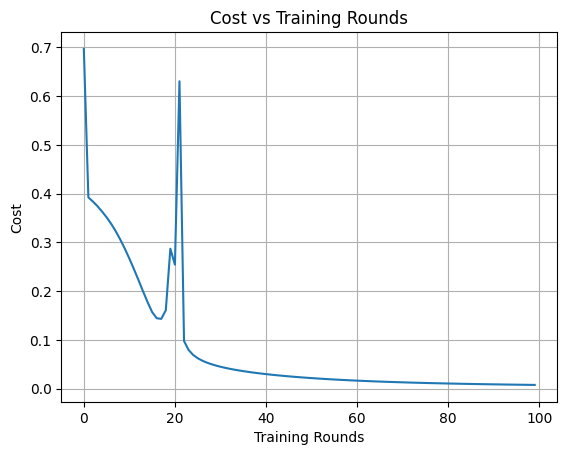

Testing on 500 samples...

Predicted: [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [3]:
# Load Dataset
file_name = 'spam.csv'
df = pd.read_csv(file_name, encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

messages = df['message'].values
labels = df['label'].values

# Batch Input
batch_size = int(input("Enter training batch size: "))
test_size = int(input("Enter testing batch size: "))

total_samples = len(messages)
if batch_size + test_size > total_samples:
    raise ValueError("batch_size + test_size exceeds total number of samples.")

# Vectorization
vectorizer = CountVectorizer()
X_all = vectorizer.fit_transform(messages).toarray()
scaler = MinMaxScaler()
X_all = scaler.fit_transform(X_all)

train_X = X_all[:batch_size]                        # Input data (messages)
train_Y = labels[:batch_size].reshape(-1, 1)        # Output (spam or ham)

test_X = X_all[batch_size:batch_size+test_size]
test_Y = labels[batch_size:batch_size+test_size].reshape(-1, 1)

# Neural Network
net = Neural(sigmoid, learning_rate=0.001)
net.add_layer(Layer(0, train_X.shape[1]))
net.add_layer(Layer(1, 32))
net.add_layer(Layer(2, 1))

# Train
epochs = 100
print(f"Training on {batch_size} samples with {epochs} epochs...")
costs = net.train(train_X, train_Y, epochs)

# Plot Cost vs Training Rounds
plt.plot(range(epochs), costs)
plt.title("Cost vs Training Rounds")
plt.xlabel("Training Rounds")
plt.ylabel("Cost")
plt.grid()
plt.show()

# Test
print(f"Testing on {test_size} samples...")
test_layer = Layer(0, test_X.shape[1])
test_layer.data = test_X
net._layers[0] = test_layer
net.forward()

predictions = np.round(net.output).astype(int)
print("\nPredicted:", predictions.reshape(-1))
print("Actual:   ", test_Y.reshape(-1))
accuracy = np.mean(predictions.reshape(-1) == test_Y.reshape(-1))
print(f"Accuracy on test set: {accuracy * 100:.2f}%")


In [5]:
user_message = input("Enter a message to check if spam or not: ")
user_vector = vectorizer.transform([user_message]).toarray()
user_vector_scaled = scaler.transform(user_vector)
net._layers[0].data = user_vector_scaled
net.forward()
prediction = int(np.round(net.output[0, 0]))
print("Spam" if prediction == 1 else "Not Spam")

Enter a message to check if spam or not: Hey John! How are you?
Not Spam
